<a href="https://colab.research.google.com/github/wikigist/ds_project/blob/main/Predicting_Global_Hits_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Necessary Libraries

In [ ]:
#importing libraries

import pandas as pd
import numpy as np
from pandas import Series,DataFrame
#from google.cloud import bigquery

## Load in Dataset

In [ ]:
df = pd.read_csv('final_music_data.csv')

In [ ]:
df['global_hit_flag'] = df['global_hit_flag'].replace({'other': 0, 'Global_Hit': 1})

In [ ]:
df.head()

,isrc,master_track,master_artist,sub_genre_name,spotify_streams,tiktok_streams,tiktok_creations,spotify_editorial_streams,youtube_total_streams,amazon_total_streams,...,spotify_streams_percentage,tiktok_streams_percentage,tiktok_creations_percentage,youtube_streams_percentage,amazon_streams_percentage,apple_streams_percentage,domestic_streams,international_streams,home_country_stream_ratio,global_hit_flag
0,AEUM72200038,Baseeb El Donia,Banah,Pop,114185,2502232,2612,60639,13196,56,...,4.333329,94.959889,0.099126,0.500789,0.002125,0.104742,4114,127465,0.031266,0
1,AEUM72000089,El A’ada El Helwa,Banah,Pop,141298,774701,1348,72809,403729,5198,...,10.637667,58.323622,0.101485,30.394872,0.391333,0.151022,4491,548311,0.008124,0
2,AEA2D2200265,Sway My Way,R3HAB,Dance,367002,0,0,120,64546,279,...,82.977309,0.000000,0.000000,14.593526,0.063080,2.366084,0,460135,0.000000,0
3,AEA2D2200224,My Pony,R3HAB,Dance,316138,0,0,13692,301838,4037,...,49.935554,0.000000,0.000000,47.676799,0.637664,1.749983,0,635726,0.000000,0
4,AEA2D2100149,Runaway,R3HAB,Dance,1287431,55,1,2134,496199,3067,...,71.799135,0.003067,0.000056,27.672674,0.171044,0.354024,7,1802898,0.000004,0


## Data Cleaning/Pre-processing

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
#df.isna()

In [ ]:
df.dtypes

isrc                                object
master_track                        object
master_artist                       object
sub_genre_name                      object
spotify_streams                      int64
tiktok_streams                       int64
tiktok_creations                     int64
spotify_editorial_streams            int64
youtube_total_streams                int64
amazon_total_streams                 int64
spotify_saves                        int64
isrc_home_country                   object
apple_stream                         int64
total_streams_in_first_30_days       int64
total_streams_in_first_90_days       int64
total_streams_ratio                float64
total_overall_streams                int64
frontline_catalogue                 object
first_stream_date                   object
saves_per_stream                   float64
spotify_editorial_streams_ratio    float64
DSPs_total_streams                   int64
spotify_streams_percentage         float64
tiktok_stre

## Feature Engineering

In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [ ]:
feature_cols = ['total_streams_ratio',
                'saves_per_stream', 
                'spotify_editorial_streams_ratio',
                'spotify_streams_percentage',
                'tiktok_streams_percentage',
                'tiktok_creations_percentage', 
                'youtube_streams_percentage', 
                'amazon_streams_percentage', 
                'apple_streams_percentage', 
                'home_country_stream_ratio']

df["isrc_home_country"] = df["isrc_home_country"].astype('category')
df["frontline_catalogue"] = df["frontline_catalogue"].astype('category')
df["sub_genre_name"] = df["sub_genre_name"].astype('category')
df['apple_streams_percentage'] = df['apple_streams_percentage'].astype(float)


# Convert categorical features to integer codes
df["isrc_home_country"] = df["isrc_home_country"].cat.codes
df["frontline_catalogue"] = df["frontline_catalogue"].cat.codes
df["sub_genre_name"] = df["sub_genre_name"].cat.codes

X = df[feature_cols]
y = df.global_hit_flag

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.30, random_state=42, stratify=y_train
)

cat = [0, 1, 2]  # Use the integer codes for categorical features

train_set = lgbm.Dataset(data=X_train, 
                         label=y_train,
                         categorical_feature=cat, 
                         free_raw_data=False)

validation_set = lgbm.Dataset(data=X_validation, 
                         label=y_validation,
                         categorical_feature=cat, 
                         free_raw_data=False)

test_set = lgbm.Dataset(data=X_test, 
                         label=y_test,
                         categorical_feature=cat, 
                         free_raw_data=False)

lgbm_params = {'max_depth': 4, 
               'learning_rate': 0.01, 
               'objective': 'binary', 
               'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1],
               'boost_from_average': False,
               'feature_fraction' : 0.7,
              }

evaluation_results = {}
model = lgbm.train(train_set=train_set, 
                   params=lgbm_params,
                   num_boost_round=10000,
                   valid_sets=[train_set, validation_set],
                   valid_names=['Train', 'Validate'], 
                   evals_result=evaluation_results,
                   verbose_eval=1,
                   early_stopping_rounds=50,
                   )

y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will

Streaming output truncated to the last 5000 lines.
[5950]	Train's binary_logloss: 0.115149	Validate's binary_logloss: 0.143456
[5951]	Train's binary_logloss: 0.115134	Validate's binary_logloss: 0.143441
[5952]	Train's binary_logloss: 0.115118	Validate's binary_logloss: 0.143424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5953]	Train's binary_logloss: 0.11511	Validate's binary_logloss: 0.143417
[5954]	Train's binary_logloss: 0.115102	Validate's binary_logloss: 0.143408
[5955]	Train's binary_logloss: 0.115077	Validate's binary_logloss: 0.143393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5956]	Train's binary_logloss: 0.115069	Validate's binary_logloss: 0.143387
[5957]	Train's binary_logloss: 0.115057	Validate's binary_logloss: 0.143379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5958]	Train's binary_logloss: 0.115049	Validate's binary_logloss: 0.143376
[5959]	Train's binary_logloss: 0.115035	V

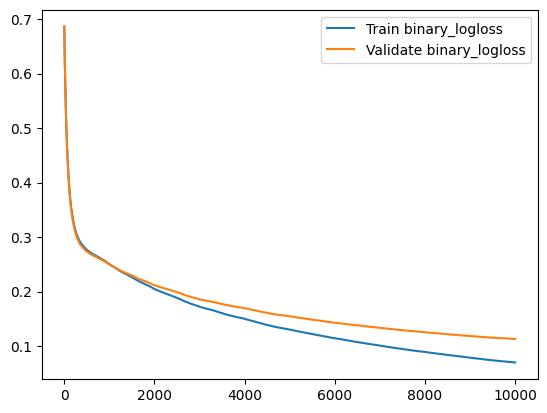

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([index for index in range(len(evaluation_results["Train"]["binary_logloss"]))],
         evaluation_results["Train"]["binary_logloss"], label="Train binary_logloss")
plt.plot([index for index in range(len(evaluation_results["Validate"]["binary_logloss"]))],
         evaluation_results["Validate"]["binary_logloss"], label="Validate binary_logloss")
plt.legend();

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")

Confusion Matrix:
 [[33958  1523]
 [  251   457]] 
Accuracy: 95.1 % 
Precision: 23.08 % 
Recall: 64.55 % 
F1: 34.0 %


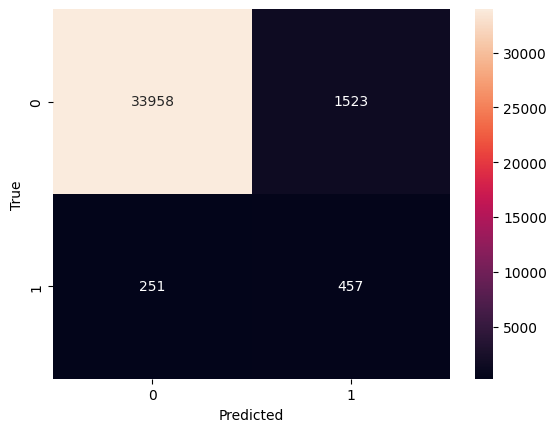

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
feature_importance = model.feature_importance()
print(feature_importance)


[    0     0     0 20925 20976 19757 21134 22042 23274 18792]


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

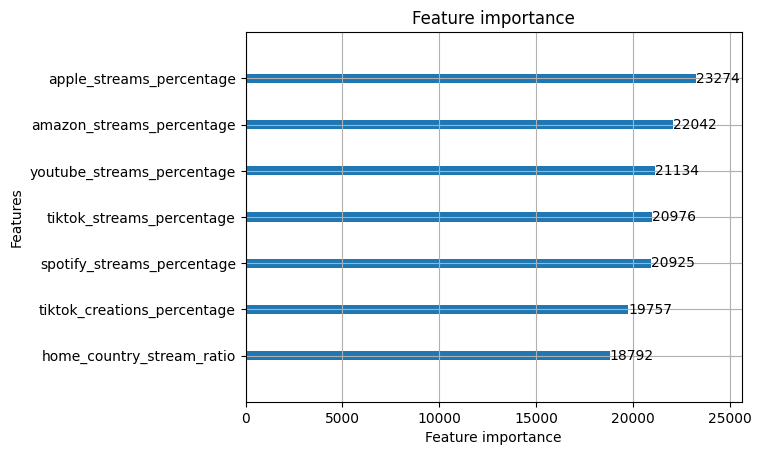

In [ ]:
lgbm.plot_importance(model)

## Tuning Model/HyperParameters Tuning

In [ ]:
from sklearn.impute import SimpleImputer

# Replace missing values in X_train with mean value of each column
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Use X_train_imputed instead of X_train in the grid search
grid_search.fit(X_train_imputed, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l2', 'none']},
             verbose=2)

## Using Logistic Regression

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Create a pipeline with the imputer and the logistic regression estimator
pipe = make_pipeline(SimpleImputer(), LogisticRegression())

# Define the parameter grid
param_grid = {'logisticregression__C': [0.1, 1, 10]}

# Create the grid search object
grid_search = GridSearchCV(pipe, param_grid, cv=3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: {}".format(grid_search.best_params_))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best hyperparameters: {'logisticregression__C': 0.1}


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create a range of values to test for each hyperparameter
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2', 'none']
}


# Create the grid search object
lr = LogisticRegression(solver='lbfgs')  # Use 'lbfgs' solver for these penalty options
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


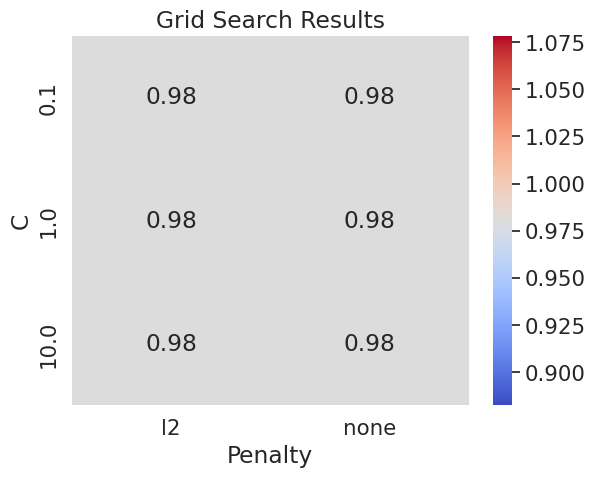

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the mean test scores from the cv_results_ dictionary
mean_scores = grid_search.cv_results_['mean_test_score']

# Reshape the mean scores into a grid
mean_scores = np.array(mean_scores).reshape(len(param_grid['C']), len(param_grid['penalty']))

# Convert the mean scores into a DataFrame
df_scores = pd.DataFrame(mean_scores, index=param_grid['C'], columns=param_grid['penalty'])

# Create a heatmap of the mean scores
sns.heatmap(df_scores, annot=True, cmap='coolwarm')

# Set the axis labels and title
plt.xlabel('Penalty')
plt.ylabel('C')
plt.title('Grid Search Results')
plt.show()


## Using HistGradientBoostingClassifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Create a range of values to test for each hyperparameter
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [2, 5, 10]
}

# Create the grid search object
gb = HistGradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Preprocess the data to handle missing values
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Fit the grid search to the data
grid_search.fit(X_train_imputed, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test dataset
test_score = grid_search.best_estimator_.score(X_test_imputed, y_test)
print(f'Test Accuracy: {test_score:.3f}')


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5}
Test Accuracy: 0.982


In [ ]:
from sklearn.metrics import confusion_matrix

# Get the best estimator found by the grid search
best_estimator = grid_search.best_estimator_

# Make predictions on the test set using the best estimator
y_pred = best_estimator.predict(X_test_imputed)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)


[[35401    80]
 [  584   124]]


<ipython-input-107-da4134344a81>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-107-da4134344a81>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


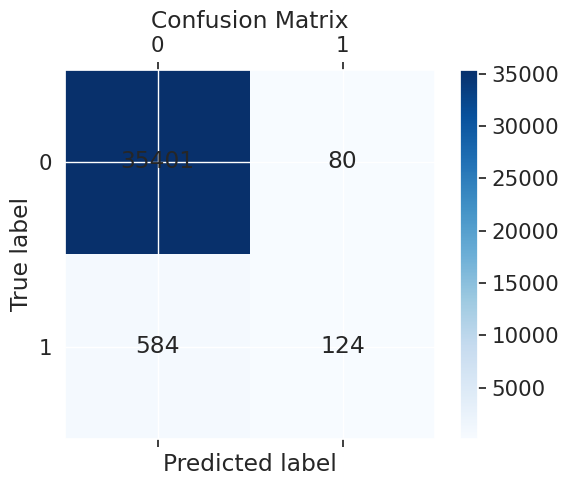

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix
confusion_matrix = np.array([[35401, 80], [584, 124]])

# Define the labels for the x and y axis
classes = ['0', '1']

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create the heatmap using matshow
heatmap = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)

# Add the colorbar
cbar = plt.colorbar(heatmap)

# Set the labels for the x and y axis
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)

# Set the title and axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# Add the values to the heatmap
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, confusion_matrix[i, j], ha='center', va='center')

# Show the plot
plt.show()


Text(0.5, 1.0, 'Grid Search Results')

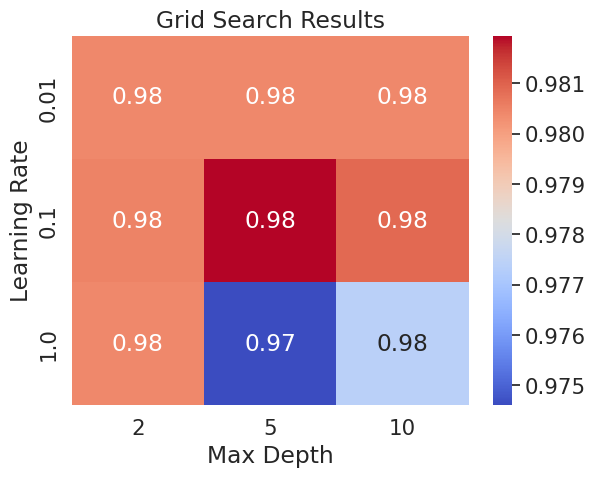

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the mean test scores from the cv_results_ dictionary
mean_scores = grid_search.cv_results_['mean_test_score']

# Reshape the mean scores into a grid
mean_scores = np.array(mean_scores).reshape(len(param_grid['learning_rate']), len(param_grid['max_depth']))

# Convert the mean scores into a DataFrame
df_scores = pd.DataFrame(mean_scores, index=param_grid['learning_rate'], columns=param_grid['max_depth'])

# Create a heatmap of the mean scores
sns.heatmap(df_scores, annot=True, cmap='coolwarm')

# Set the axis labels and title
plt.xlabel('Max Depth')
plt.ylabel('Learning Rate')
plt.title('Grid Search Results')


In [ ]:
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35481
           1       0.66      0.17      0.27       708

    accuracy                           0.98     36189
   macro avg       0.82      0.59      0.63     36189
weighted avg       0.98      0.98      0.98     36189



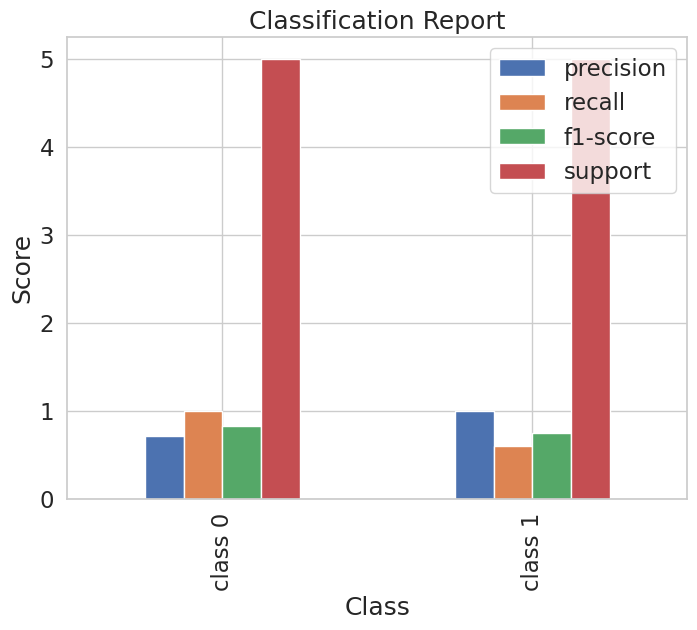

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define the true and predicted labels
y_true = [0, 1, 0, 1, 0, 0, 1, 1, 0, 1]
y_pred = [0, 0, 0, 1, 0, 0, 1, 0, 0, 1]

# Define the target names
target_names = ['class 0', 'class 1']

# Create the classification report
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

# Extract the scores into a dictionary
scores = {'precision': {}, 'recall': {}, 'f1-score': {}, 'support': {}}
for target_name in target_names:
    for score_name in scores.keys():
        scores[score_name][target_name] = report[target_name][score_name]

# Convert the scores dictionary into a DataFrame
df_scores = pd.DataFrame.from_dict(scores)

# Plot the scores
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
df_scores.plot(kind='bar', figsize=(8, 6))
plt.title('Classification Report')
plt.xlabel('Class')
plt.ylabel('Score')
plt.show()


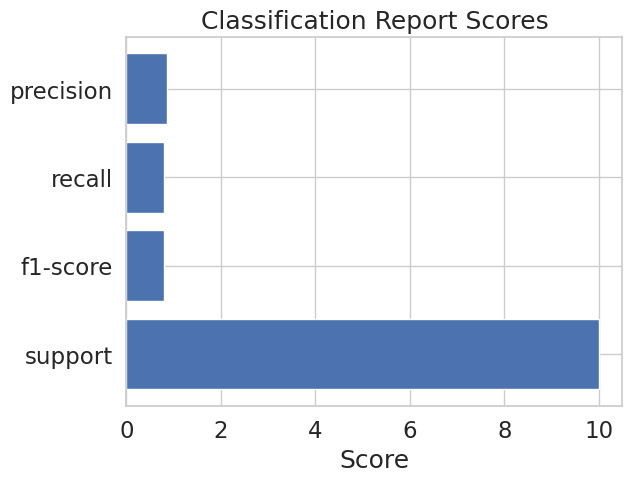

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# create a classification report
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

# extract the scores into a dictionary
scores = report['weighted avg']

# create a horizontal bar chart
fig, ax = plt.subplots()
y_pos = range(len(scores))
ax.barh(y_pos, scores.values(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(scores.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Classification Report Scores')

plt.show()


{'learning_rate': 0.01, 'max_depth': 2}: 0.980 (+/- 0.000)
{'learning_rate': 0.01, 'max_depth': 5}: 0.980 (+/- 0.000)
{'learning_rate': 0.01, 'max_depth': 10}: 0.980 (+/- 0.000)
{'learning_rate': 0.1, 'max_depth': 2}: 0.980 (+/- 0.000)
{'learning_rate': 0.1, 'max_depth': 5}: 0.982 (+/- 0.000)
{'learning_rate': 0.1, 'max_depth': 10}: 0.981 (+/- 0.001)
{'learning_rate': 1, 'max_depth': 2}: 0.941 (+/- 0.055)
{'learning_rate': 1, 'max_depth': 5}: 0.961 (+/- 0.026)
{'learning_rate': 1, 'max_depth': 10}: 0.976 (+/- 0.001)


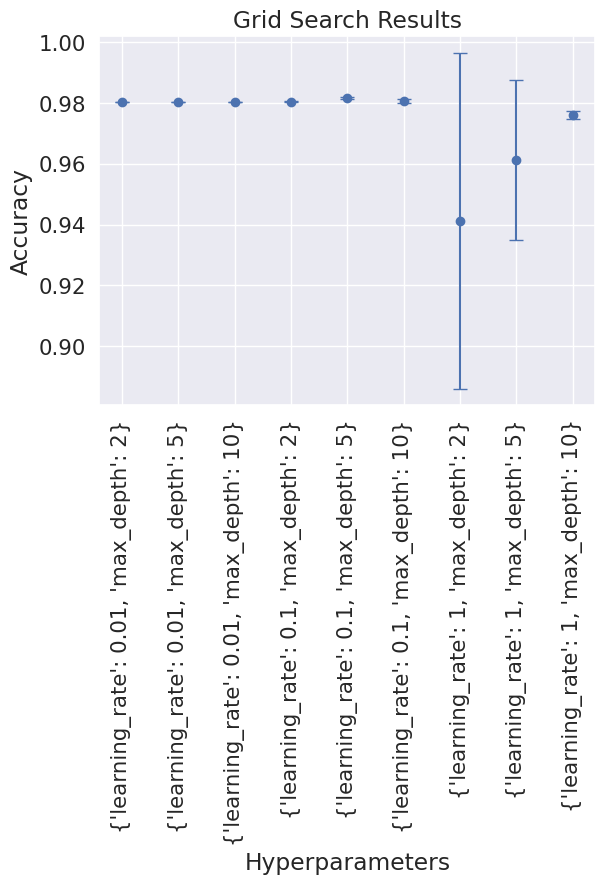

In [ ]:
# Get the mean and standard deviation of the scores for each hyperparameter combination
results = grid_search.cv_results_
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

# Extract the hyperparameters from the results
params = results['params']

# Print the hyperparameters and their scores
for param, mean_score, std_score in zip(params, mean_scores, std_scores):
    print(f"{param}: {mean_score:.3f} (+/- {std_score:.3f})")

# Plot the results
plt.errorbar(range(len(mean_scores)), mean_scores, yerr=std_scores, fmt='o', capsize=5)
plt.xticks(range(len(mean_scores)), [str(p) for p in params], rotation=90)
plt.title('Grid Search Results')
plt.ylabel('Accuracy')
plt.xlabel('Hyperparameters')
plt.show()


In [ ]:
from sklearn.impute import SimpleImputer

# create the imputer transformer
imputer = SimpleImputer()

# fit the imputer transformer on the training data and transform the test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# train the logistic regression model on the imputed data
model = LogisticRegression(C=0.1, penalty='l2')
model.fit(X_train_imputed, y_train)

# evaluate the model on the imputed test dataset
test_score = model.score(X_test_imputed, y_test)
print(f'Test Accuracy: {test_score:.3f}')


Test Accuracy: 0.980


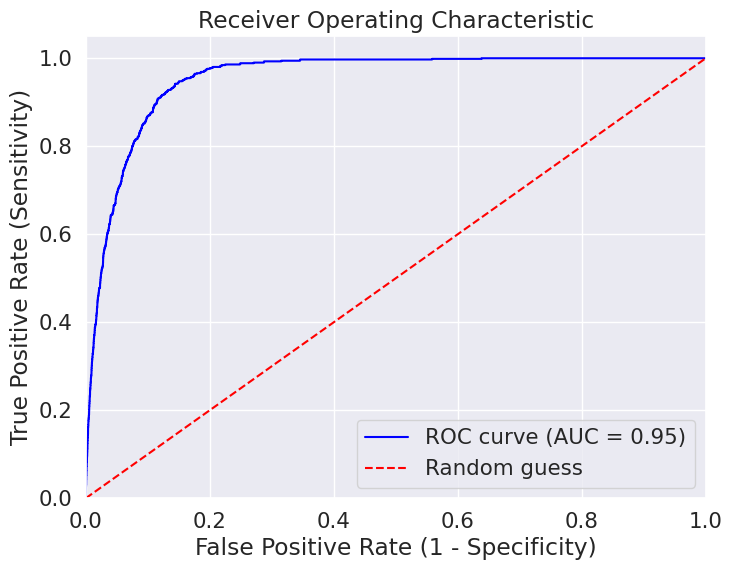

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the test data
y_pred_prob = model.predict(X_test)

# Compute fpr, tpr, and thresholds using the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from imblearn.over_sampling import SMOTE

# define the SMOTE resampling method
sm = SMOTE(random_state=42)

# fit the SMOTE model on the training data
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# print the shapes of the resampled data
print("Original train set shape:", X_train.shape, y_train.shape)
print("Resampled train set shape:", X_train_res.shape, y_train_res.shape)


Original train set shape: (59108, 10) (59108,)
Resampled train set shape: (115902, 10) (115902,)


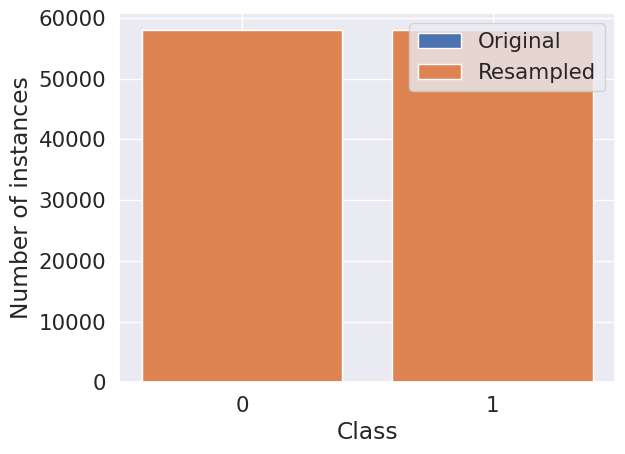

In [ ]:
import matplotlib.pyplot as plt

# count the number of instances for each class in the original and resampled training data
original_counts = pd.Series(y_train).value_counts().sort_index()
resampled_counts = pd.Series(y_train_res).value_counts().sort_index()

# create a bar chart to show the number of instances for each class
fig, ax = plt.subplots()
ax.bar(original_counts.index, original_counts.values, label='Original')
ax.bar(resampled_counts.index, resampled_counts.values, label='Resampled')
ax.set_xticks(original_counts.index)
ax.set_xlabel('Class')
ax.set_ylabel('Number of instances')
ax.legend()
plt.show()


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Instantiate the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the training data
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Print the original and resampled shapes
print("Original train set shape:", X_train.shape, y_train.shape)
print("Resampled train set shape:", X_resampled.shape, y_resampled.shape)


Original train set shape: (59108, 10) (59108,)
Resampled train set shape: (115902, 10) (115902,)


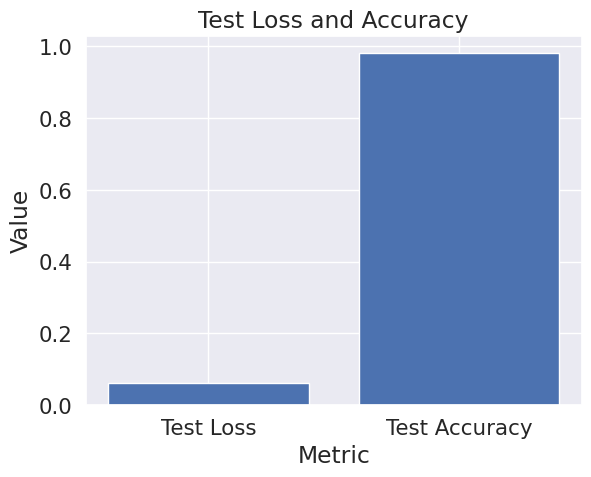

In [ ]:
import matplotlib.pyplot as plt

# Set the values for test loss and accuracy
test_loss = 0.06115990877151489
test_accuracy = 0.9808505177497864

# Create a bar plot
values = [test_loss, test_accuracy]
labels = ['Test Loss', 'Test Accuracy']
plt.bar(labels, values)

# Add labels and title to the plot
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Test Loss and Accuracy')

# Display the plot
plt.show()


## Test Run a Subtle Prediction using LightGBM Model

In [ ]:
import pandas as pd
import lightgbm as lgb

# Load the data
df = pd.read_csv('final_music_data.csv')

# Select the feature columns
feature_cols = ['total_streams_ratio', 
                'saves_per_stream', 
                'spotify_editorial_streams_ratio', 
                'spotify_streams_percentage', 
                'tiktok_streams_percentage', 
                'tiktok_creations_percentage', 
                'youtube_streams_percentage', 
                'amazon_streams_percentage', 
                'apple_streams_percentage', 
                'home_country_stream_ratio']

# Convert categorical features to category type
df["isrc_home_country"] = df["isrc_home_country"].astype('category')
df["frontline_catalogue"] = df["frontline_catalogue"].astype('category')
df["sub_genre_name"] = df["sub_genre_name"].astype('category')

# Convert apple_streams_percentage to float
df['apple_streams_percentage'] = df['apple_streams_percentage'].astype(float)

# Convert categorical features to integer codes
df["isrc_home_country"] = df["isrc_home_country"].cat.codes
df["frontline_catalogue"] = df["frontline_catalogue"].cat.codes
df["sub_genre_name"] = df["sub_genre_name"].cat.codes

# Split the data into training and testing sets
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

# Prepare the training and testing data
X_train = train_data[feature_cols]
y_train = train_data['global_hit_flag']
X_test = test_data[feature_cols]
y_test = test_data['global_hit_flag']

# Define the LightGBM model
model = lgb.LGBMClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make prediction on new track
new_track_features = [0.2, 0.3, 0.4, 0.1, 0.1, 0.1, 0.05, 0.02, 0.03, 0.8]
prediction = model.predict([new_track_features])

print('Likelihood of becoming a global hit:', prediction[0])


Likelihood of becoming a global hit: other


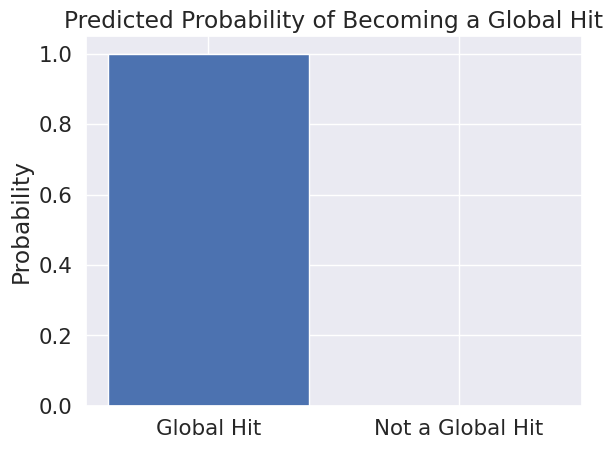

In [ ]:
import matplotlib.pyplot as plt

# Train the model
model.fit(X_train, y_train)

prediction_prob = model.predict_proba([new_track_features])
prob_global_hit = prediction_prob[0][1]  # Probability of becoming a global hit

plt.bar(['Global Hit', 'Not a Global Hit'], [prob_global_hit, 1-prob_global_hit])
plt.ylabel('Probability')
plt.title('Predicted Probability of Becoming a Global Hit')
plt.show()
